# Impact of Homepage Discovery features

We've deployed several features that provide new users with information about the Homepage's existance. The phab task for this analysis ([T228338](https://phabricator.wikimedia.org/T228338)) gives an overview of the four changes that were made.

In our [leading indicator report](https://www.mediawiki.org/wiki/Growth/Personalized_first_day/Newcomer_homepage/Measurement_and_experiment_plan#Status_of_leading_indicators), we found that the Homepage visitor rate on Czech is 30.4%, and on Korean it is 22.7%. These numbers are for desktop users only. The goal of the Homepage Discovery features was to increase this by 100%, meaning the numbers double to 60.8% and 45.4%, but we'd prefer if the Korean rate was in the 50–60% range.

We have four features, so let's figure out when these were deployed:

1. Email confirmation page ([T222848](https://phabricator.wikimedia.org/T222848)). Deployment date is not mentioned in the Phab task, we can use the data to figure out when it first was used in production.
2. Link from Special:Contributions (desktop) ([T225328](https://phabricator.wikimedia.org/T225328)). Deployment date is not specified in the task.
3. Link from Special:Contributions (mobile) ([T227575](https://phabricator.wikimedia.org/T227575)). Deployment date is not specified in the task.
4. Guided tour ([T222852](https://phabricator.wikimedia.org/T222852)). Deployment date is not mentioned in the Phab task.

It looks like all these were deployed as part of the train that week. In other words, we'll look them up in the data to identify when they were first being used in production, and set that as the timestamp of when the change occurred.

In [1]:
import json
import datetime as dt

import tabulate
import pymysql

import numpy as np
import pandas as pd

from wmfdata import hive, mariadb

You can find the source for `wmfdata` at https://github.com/neilpquinn/wmfdata


In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(data.table)
library(ggplot2)
library(pwr)

In [4]:
## Configuration variables

## Czech Wikipedia setup:

## User IDs of known users to exclude (Stephane, Elena, and Marshall's accounts)
cs_known_users = set([322106, 339583, 341191, 341611, 433381, 433382, 433511, 404765, 421667,
                      427625, 437386, 181724, 272273, 339583, 437386, 439783, 439792, 138342,
                      392634, 404765, 275298, 458487, 458049])

## Korean Wikipedia setup:

## User IDs of known users to exclude
ko_known_users = set([384066, 539296, 539299, 539302, 539303, 539304, 539305, 539306, 539307,
                      539298, 416361, 416360, 413162, 495265, 518393, 518394, 518396, 530285,
                      531579, 531785, 536786, 536787, 542720, 542721, 542722, 543192, 543193,
                      544145, 544283, 470932, 38759, 555673])

In [5]:
## Grab the user IDs of known test accounts so they can be added to the exclusion list

username_patterns = ["MMiller", "Zilant", "Roan", "KHarlan", "MWang", "SBtest", "Rho2019"]

known_user_query = '''
SELECT user_id
FROM user
WHERE user_name LIKE "{name_pattern}%"
'''

for u_pattern in username_patterns:
    cs_new_known = mariadb.run(known_user_query.format(
        name_pattern = u_pattern), 'cswiki')
    cs_known_users = cs_known_users | set(cs_new_known['user_id'])

for u_pattern in username_patterns:
    ko_new_known = mariadb.run(known_user_query.format(
        name_pattern = u_pattern), 'kowiki')
    ko_known_users = ko_known_users | set(ko_new_known['user_id'])

## First usage of new paths to the Homepage

This means answering two questions:

1. What are the potential ways of getting to the Homepage?
2. What is the first use of these ways in production (by a non-test user)?

In this case, we can use the Homepage schemas even though they don't include the first few days of the experiment, because we're going to do an interrupted time-series analysis, meaning we're more interested what happened around the time of deployment of the *new* features than what happened when the Homepage was first released.

In [6]:
## Query to get Homepage paths and first timestamps from the Data Lake
first_discovery_query = '''
SELECT wiki, event.referer_route, MIN(dt) AS first_visit_ts
FROM event_sanitized.homepagevisit
WHERE year = 2019
AND month BETWEEN 5 AND 8
AND ((wiki = "cswiki"
      AND event.user_id NOT IN ({cs_known_list}))
      OR
      (wiki = "kowiki"
      AND event.user_id NOT IN ({ko_known_list})))
GROUP BY wiki, event.referer_route
LIMIT 100
'''

In [7]:
first_route_usage = hive.run(
    first_discovery_query.format(
        cs_known_list = ', '.join([str(u) for u in cs_known_users]),
        ko_known_list = ', '.join([str(u) for u in ko_known_users])
    )
)

In [8]:
first_route_usage

,wiki,referer_route,first_visit_ts
0,cswiki,direct,2019-05-19T21:08:56Z
1,cswiki,other,2019-05-14T10:13:18Z
2,cswiki,personaltoolslink,2019-05-14T10:12:44Z
3,cswiki,specialconfirmemail,2019-07-12T10:44:14Z
4,cswiki,specialcontributions,2019-07-26T10:03:44Z
5,cswiki,specialwelcomesurvey,2019-07-25T13:05:23Z
6,cswiki,userpagetab,2019-05-14T06:39:32Z
7,cswiki,usertalkpagetab,2019-05-15T13:39:46Z
8,kowiki,direct,2019-06-13T16:58:57Z
9,kowiki,other,2019-05-16T07:58:11Z


Based on this, it appears that the link from Special:ConfirmEmail was deployed on or around 2019-07-12 10:00 UTC. The link from the Welcome Survey was deployed on or around 2019-07-25 13:00 UTC. Finally, the link from Special:Contributions was deployed on 2019-07-26 10:00 UTC, but perhaps later on Korean.

This means that we have an about two week period in mid-July during which only the link from Special:ConfirmEmail was deployed. Then, we have a 24-hour period during which we also have a link from the Welcome Survey, before all three variants are available. This means that if we're comparing rates, the final comparison period would be from 2019-07-26 10:00 UTC onwards, while the first comparison period should end before 2019-07-12 10:00 UTC.

## Study period and data gathering

Given that this was deployed in mid-July, let's use June and August as steady periods and gather data from June 1 to Sept 1. We want info on all users who registered on Czech and Korean during that period, whether it was on desktop or mobile, whether they turned the Homepage on or off (for exclusion), and what the time of their first visit to the Homepage was.

In [9]:
user_activity_query = '''
WITH regs AS (
    SELECT wiki, event.userid AS user_id, dt AS reg_ts, event.displaymobile AS reg_mobile
    FROM event_sanitized.serversideaccountcreation
    WHERE year = 2019
    AND month BETWEEN 6 AND 8
    AND ((wiki = "cswiki"
          AND event.userid NOT IN ({cs_known_list}))
          OR
         (wiki = "kowiki"
          AND event.userid NOT IN ({ko_known_list})))
    AND COALESCE(event.isapi, false) = false
    AND event.isselfmade = 1
),
pref_switch AS (
    SELECT wiki, event.userid AS user_id
    FROM event_sanitized.prefupdate
    WHERE year = 2019
    AND month BETWEEN 6 AND 8
    AND ((wiki = "cswiki"
          AND event.userid NOT IN ({cs_known_list}))
          OR
         (wiki = "kowiki"
          AND event.userid NOT IN ({ko_known_list})))
    AND event.property = "growthexperiments-homepage-enable"
),
hp_visits AS (
    SELECT wiki, event.user_id, dt AS visit_ts, event.is_mobile AS visit_mobile,
    event.referer_route, ROW_NUMBER() OVER (PARTITION BY wiki, event.user_id ORDER BY dt) AS visit_no
    FROM event_sanitized.homepagevisit
    WHERE year = 2019
    AND month BETWEEN 6 AND 8
    AND ((wiki = "cswiki"
          AND event.user_id NOT IN ({cs_known_list}))
          OR
         (wiki = "kowiki"
          AND event.user_id NOT IN ({ko_known_list})))
)
SELECT regs.wiki, regs.user_id, reg_ts, reg_mobile, visit_ts, visit_mobile, referer_route,
    IF(pref_switch.user_id IS NOT NULL, 1, 0) AS pref_switched
FROM regs
LEFT JOIN hp_visits
ON (regs.wiki = hp_visits.wiki AND regs.user_id = hp_visits.user_id)
LEFT JOIN pref_switch
ON (regs.wiki = pref_switch.wiki AND regs.user_id = pref_switch.user_id)
WHERE (visit_no IS NULL
       OR visit_no = 1)
'''

In [10]:
user_activity = hive.run(
    user_activity_query.format(
        cs_known_list = ', '.join([str(u) for u in cs_known_users]),
        ko_known_list = ', '.join([str(u) for u in ko_known_users])
    )
)

In [11]:
def get_panel_prefs(wiki, prop, include_users = None, exclude_users = None):
    '''
    Query and return a `pandas.DataFrame` with a column `user_id` of all users who have
    the given property turned on in their preferences.
    
    :param wiki: database code of the wiki we're querying
    :type wiki: str
    
    :param prop: the user preference were use for determining treatment/control membership
    :type prop: str
    
    :param include_users: user IDs of the users we are interested in
    :type include_users: iterator
    
    :param exclude_users: user IDs of users we are not interested in
    :type exclude_users: iterator
    '''
    
    panel_query = '''
    SELECT up_user AS user_id, CAST(up_value AS UNSIGNED INTEGER) AS is_treatment
    FROM user_properties
    WHERE up_property = "{prop}"
    '''.format(wiki = wiki, prop = prop)
    
    if include_users is not None:
        panel_query += '''
        AND up_user IN ({})
        '''.format(','.join([str(uid) for uid in include_users]))
        
    if exclude_users is not None:
        panel_query += '''
        AND up_user NOT IN ({})
        '''.format(', '.join([str(uid) for uid in exclude_users]))
        
    return(mariadb.run(panel_query, wiki))
    
cs_panel_prefs = get_panel_prefs('cswiki', "growthexperiments-homepage-enable",
                                  exclude_users = cs_known_users)
ko_panel_prefs = get_panel_prefs('kowiki', "growthexperiments-homepage-enable",
                                  exclude_users = ko_known_users)

In [12]:
cs_panel_prefs['wiki'] = 'cswiki'
ko_panel_prefs['wiki'] = 'kowiki'

panel_prefs = pd.concat([cs_panel_prefs, ko_panel_prefs])

In [13]:
user_data = user_activity.merge(panel_prefs, how = 'left', on = ['wiki', 'user_id'])

In [14]:
## Exclude all users who switched the Homepage on or off
user_data = user_data.loc[user_data.pref_switched == 0]

In [15]:
user_data.loc[user_data.is_treatment.isna(), 'is_treatment'] = 0

In [16]:
user_data['reg_dt']  = user_data['reg_ts']
user_data['visit_dt'] = user_data['visit_ts']

In [17]:
## Parse the timesetamps
user_data['reg_ts'] = pd.to_datetime(user_data.reg_dt, format = '%Y-%m-%dT%H:%M:%SZ')
user_data['visit_ts'] = pd.to_datetime(user_data.visit_dt, format = '%Y-%m-%dT%H:%M:%SZ')

In [18]:
user_data['visit_diff'] = user_data.visit_ts - user_data.reg_ts

In [19]:
user_data['reg_date'] = user_data.reg_ts.apply(lambda x: x.date())

Now, we want to aggregate per day the number of users who registered on desktop and the number of users who visited on the desktop within 24 hours after registration.

In [20]:
def homepage_visits(group):
    aggs = {
        'n_reg' : len(group),
        'n_visits' : len(group.loc[(group.visit_mobile == False) &
                                   (group.visit_diff < dt.timedelta(days = 2))])
    }
    return(pd.Series(aggs, index = aggs.keys()))

user_data_agg = (user_data.loc[(user_data.is_treatment == 1) &
                               (user_data.reg_mobile == False) &
                               (user_data.reg_date < dt.date(2019, 8, 29))]
                 .groupby(['wiki', 'reg_date']).apply(homepage_visits))

In [21]:
user_data_agg = user_data_agg.reset_index()
user_data_agg['reg_date'] = user_data_agg.reg_date.apply(lambda x: x.strftime('%Y-%m-%d'))

R[write to console]: 
Attaching package: ‘zoo’


R[write to console]: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




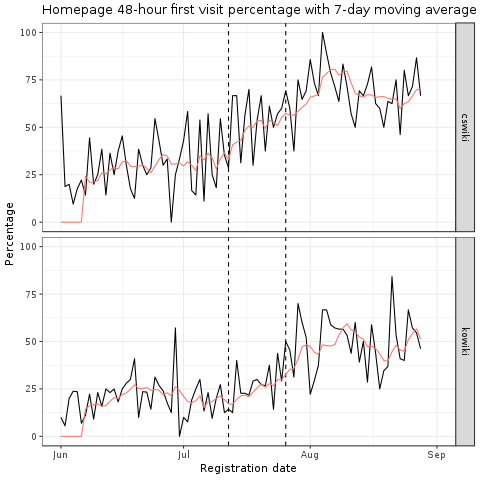

In [22]:
%%R -i user_data_agg

library(zoo)

user_data_agg = data.table(user_data_agg)
user_data_agg[, reg_date := as.Date(reg_date)]
user_data_agg[, visit_prop := 100 * n_visits / n_reg]

user_data_agg[
  , visit_prop.ma7 := rollapply(visit_prop,
                               width=7,
                               FUN=mean,
                               na.rm=TRUE,
                               fill=0,
                               align='right'),
    by = wiki];

g = ggplot(user_data_agg, aes(x = reg_date, y = visit_prop)) +
theme_bw() +
facet_grid(wiki ~ .) +
scale_x_date("Registration date", limits = c(as.Date('2019-06-01'), as.Date('2019-09-01'))) +
scale_y_continuous("Percentage") +
ggtitle("Homepage 48-hour first visit percentage with 7-day moving average") +
geom_vline(xintercept = as.Date('2019-07-12'),
             linetype='dashed') +
geom_vline(xintercept = as.Date('2019-07-26'),
             linetype='dashed') +
geom_line() +
geom_line(aes(y = visit_prop.ma7, color = 'red')) +
guides(color = FALSE)

ggsave(plot = g, file = "graphs/homepage_48hour_visit_rate_with_ma.png",
       width = 8, height = 6, units = "in", dpi = "retina")
g

## Analysis of effect

There's a two-week window during which some, but not all, of the features were deployed. This makes determining the effect somewhat difficult because we're not only working with the effect itself but also other effects such as vacations (or lack of such). Ideally, we'd have a single inflection point. We don't, so we'll make do with what we've got.

I'll use the two weeks prior to the first deployment, and the two weeks after the last deployment as the before and after periods, respectively. I use a week as a basis because we know wiki activity moves in a weekly cycle, and two weeks in order to get some stability. As we know from literature, figuring out the size of the window is complicated and why Interrupted Time Series analysis and regressions are useful, but I think using one of those is unnecessary for this analysis.

First, let's determine the start and end of each time period. Last date before deployment is 2019-07-11, two weeks before that was:

In [23]:
dt.date(2019, 7, 11) - dt.timedelta(days = 14)

datetime.date(2019, 6, 27)

Last date of deploment was 2019-07-26, two weeks after that is:

In [24]:
dt.date(2019, 7, 26) + dt.timedelta(days = 14)

datetime.date(2019, 8, 9)

Now we can use those to calculate the before and after proportions.

In [25]:
def calc_pre_post(df, wiki):
    '''
    For the given wiki, calculate the proportion of registrations that visited the Homepage prior
    to deployment (2019-06-28 to 2019-07-12), and after deployment
    (2019-07-26 to 2019-08-09).
    '''
    
    pre_sums = df.loc[(df.wiki == wiki) & (df.reg_date >= '2019-06-28') &
                      (df.reg_date < '2019-07-12')][['n_visits', 'n_reg']].sum()
    post_sums = df.loc[(df.wiki == wiki) & (df.reg_date >= '2019-07-26') &
                       (df.reg_date < '2019-08-09')][['n_visits', 'n_reg']].sum()
    
    return((pre_sums.n_visits / pre_sums.n_reg, post_sums.n_visits / post_sums.n_reg))

In [26]:
cs_props = calc_pre_post(user_data_agg, 'cswiki')
ko_props = calc_pre_post(user_data_agg, 'kowiki')

### Czech Wikipedia

On the Czech Wikipedia, the percentage of visits before deployment across the 14-day window was:

In [27]:
round(100 * cs_props[0], 1)

34.1

The percentage of visits after deployment (again using a 14-day window) was:

In [28]:
round(100 * cs_props[1], 1)

71.9

The increase (in percent) in Czech is:

In [29]:
round(100 * (cs_props[1] - cs_props[0]) / cs_props[0], 1)

111.0

Note that this exceeded the stated goal of 100% increase.

### Korean Wikipedia

On the Korean Wikipedia, the percentage of visits before deployment across the 14-day window was:

In [30]:
round(100 * ko_props[0], 1)

19.1

The percentage of visits after deployment (again using a 14-day window) was:

In [31]:
round(100 * ko_props[1], 1)

49.3

The increase (in percent) in Korean is:

In [32]:
round(100 * (ko_props[1] - ko_props[0]) / ko_props[0], 1)

158.1

Note that this also exceeded the stated goal of 100%.

## The paths that users take

The second part of the phab task for this analysis ask for an overview of the paths that users take to get to the Homepage after the discovery features have been deployed.

* We will want to see what percent of newcomers first visit their homepage from each of these sources, as well as from the existing discovery paths of personal tools link and tabs from the User or User Talk page.

So, for all users who registered and first visited on desktop within 48 hours after registration, what paths did they take?

Let's first figure out what 28 days after deployment is (we'll use that instead of a whole month):

In [33]:
dt.date(2019, 7, 26) + dt.timedelta(days = 28)

datetime.date(2019, 8, 23)

In [34]:
visit_paths = (user_data.loc[(user_data.is_treatment == 1) &
                             (user_data.visit_diff < dt.timedelta(days = 2)) &
                             (user_data.reg_date >= dt.date(2019, 7, 26)) &
                             (user_data.reg_date < dt.date(2019, 8, 23))]
               .groupby(['wiki', 'visit_mobile', 'referer_route'])
               .count()['reg_date']
               .reset_index()
               .rename(columns = {'reg_date' : 'n'}))
visit_paths['percent'] = (100 * visit_paths['n'] /
                          visit_paths.groupby(['wiki', 'visit_mobile'])['n'].transform('sum'))

In [35]:
print(tabulate.tabulate(visit_paths.sort_values(['wiki', 'visit_mobile', 'n'],
                                                ascending = [True, False, False]).round(1),
                        tablefmt = "github", headers = "keys", showindex = None))

| wiki   | visit_mobile   | referer_route        |   n |   percent |
|--------|----------------|----------------------|-----|-----------|
| cswiki | True           | specialwelcomesurvey |  56 |      60.9 |
| cswiki | True           | specialconfirmemail  |  16 |      17.4 |
| cswiki | True           | specialcontributions |  10 |      10.9 |
| cswiki | True           | personaltoolslink    |   6 |       6.5 |
| cswiki | True           | userpagetab          |   4 |       4.3 |
| cswiki | False          | specialwelcomesurvey | 115 |      55.8 |
| cswiki | False          | personaltoolslink    |  54 |      26.2 |
| cswiki | False          | specialconfirmemail  |  30 |      14.6 |
| cswiki | False          | specialcontributions |   3 |       1.5 |
| cswiki | False          | userpagetab          |   2 |       1   |
| cswiki | False          | usertalkpagetab      |   2 |       1   |
| kowiki | True           | specialwelcomesurvey |  71 |      71.7 |
| kowiki | True           | specia